# EDA


## Summary

- Preprocessing
  - cols_null_all = ["fullscreen", "hq", "music"]
- CV Strategy
  - GroupKFold
    - Group=session_id
  - level_groupは極端な偏りがあるわけではなさそうなので調整しない
- Feature Engineering
  - level_groupで特徴量を分けず、session_idごとにlevel_groupを横断した特徴を作る
    - 学習データを分けないことでモデルが横断した特徴を学習させたほうがいい気がする（←edaでなにか確かめられる？）


In [1]:
import sys

sys.path.append("../src/")

In [2]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
input_dir = pathlib.Path("../data/raw")

train = pd.read_csv(input_dir / "train.csv")
train_labels = pd.read_csv(input_dir / "train_labels.csv")
test = pd.read_csv(input_dir / "test.csv")
sample_submission = pd.read_csv(input_dir / "sample_submission.csv")

In [6]:
dfs = {
    "train": train,
    "train_labels": train_labels,
    "test": test,
    "sample_submission": sample_submission,
}


for name, df in dfs.items():
    print("\n\n===", name, "===")
    print(df.shape)
    display(df.head())
    print(df.info())



=== train ===
(26296946, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      int64  
 1   index           int64  
 2   elapsed_time    int64  
 3   event_name      object 
 4   name            object 
 5   level           int64  
 6   page            float64
 7   room_coor_x     float64
 8   room_coor_y     float64
 9   screen_coor_x   float64
 10  screen_coor_y   float64
 11  hover_duration  float64
 12  text            object 
 13  fqid            object 
 14  room_fqid       object 
 15  text_fqid       object 
 16  fullscreen      int64  
 17  hq              int64  
 18  music           int64  
 19  level_group     object 
dtypes: float64(6), int64(7), object(7)
memory usage: 3.9+ GB
None


=== train_labels ===
(424116, 2)


,session_q_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424116 entries, 0 to 424115
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   session_q_id  424116 non-null  object
 1   correct       424116 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.5+ MB
None


=== test ===
(3728, 21)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,session_level
0,20090109393214576,0,0,cutscene_click,basic,0,NaN,-413.991405,75.685314,380.0,...,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4,0
1,20090109393214576,1,1965,person_click,basic,0,NaN,-105.991405,-63.314686,688.0,...,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0
2,20090109393214576,2,3614,person_click,basic,0,NaN,-418.991405,47.685314,375.0,...,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0
3,20090109393214576,3,5330,person_click,basic,0,NaN,-110.991405,-57.314686,683.0,...,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0
4,20090109393214576,4,6397,person_click,basic,0,NaN,-110.991405,-57.314686,683.0,...,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3728 entries, 0 to 3727
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   session_id      3728 non-null   int64  
 1   index           3728 non-null   int64  
 2   elapsed_time    3728 non-null   int64  
 3   event_name      3728 non-null   object 
 4   name            3728 non-null   object 
 5   level           3728 non-null   int64  
 6   page            153 non-null    float64
 7   room_coor_x     3366 non-null   float64
 8   room_coor_y     3366 non-null   float64
 9   screen_coor_x   3366 non-null   float64
 10  screen_coor_y   3366 non-null   float64
 11  hover_duration  353 non-null    float64
 12  text            1162 non-null   object 
 13  fqid            2505 non-null   object 
 14  room_fqid       3728 non-null   object 
 15  text_fqid       1162 non-null   object 
 16  fullscreen      3728 non-null   int64  
 17  hq              3728 non-null   i

,session_q_id,correct,session_level
0,20090109393214576_q1,0,0
1,20090312143683264_q1,0,0
2,20090312331414616_q1,0,0
3,20090109393214576_q2,0,0
4,20090312143683264_q2,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   session_q_id   54 non-null     object
 1   correct        54 non-null     int64 
 2   session_level  54 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ KB
None


### カラムの意味

- session_id - イベントが発生したセッションのID
- index - セッション内でのイベントのインデックス
- elapsed_time - セッションの開始からイベントの記録までに経過した時間（ミリ秒単位）
- event_name - イベントの種類の名前
- name - イベント名（例えば、ノートブックをクリックしたのが開くか閉じるかを識別する）
- level - イベントが発生したゲームのレベル（0から22）
- page - イベントのページ番号（ノートブック関連のイベントのみ）
- room_coor_x - クリックした場所のゲーム内の部屋に対する座標（クリックイベントのみ）
- room_coor_y - クリックした場所のゲーム内の部屋に対する座標（クリックイベントのみ）
- screen_coor_x - クリックした場所のプレイヤーの画面に対する座標（クリックイベントのみ）
- screen_coor_y - クリックした場所のプレイヤーの画面に対する座標（クリックイベントのみ）
- hover_duration - ホバーイベントが発生した時間（ミリ秒単位）（ホバーイベントのみ）
- text - プレイヤーがこのイベントで見たテキスト
- fqid - イベントの完全修飾ID
- room_fqid - イベントが発生した部屋の完全修飾ID
- text_fqid - イベントに関連するテキストの完全修飾ID
- fullscreen - プレイヤーがフルスクリーンモードかどうか
- hq - ゲームが高品質モードかどうか
- music - ゲームの音楽がオンかオフか
- level_group - この行が属するレベルグループ（および質問グループ）（0-4、5-12、13-22）

## Todo memo

- カテゴリと数字データは分けて分析したい
  - train, testでカテゴリデータは網羅されていると思ってよい？ない場合はnullで補完する必要がある
- 予測対象のユーザはユニーク？
- 特徴量はグループごとに作成し、0-4の特徴量でq_id in(0,1,2,3,4)を予測する？

## Num Unique session_id

In [7]:
train_labels.rename(columns={"session_id": "session_q_id"}, inplace=True)
sample_submission.rename(columns={"session_id": "session_q_id"}, inplace=True)

In [8]:
train["session_q_id"] = train["session_id"].astype(str) + "_q" + train["level"].astype(str)
test["session_q_id"] = test["session_id"].astype(str) + "_q" + test["level"].astype(str)

In [9]:
train_labels = train_labels.assign(
    level=train_labels["session_q_id"].apply(lambda x: x.split('_')[1][-1]).astype(int),
    session_id=train_labels["session_q_id"].apply(lambda x: x.split('_')[0])
)
sample_submission = sample_submission.assign(
    level=sample_submission["session_q_id"].apply(lambda x: x.split('_')[1][-1]).astype(int),
    session_id=sample_submission["session_q_id"].apply(lambda x: x.split('_')[0])
)

In [10]:
dfs = {
    "train": train,
    "train_labels": train_labels,
    "test": test,
    "sample_submission": sample_submission,
}

for name, df in dfs.items():
    print("\n\n===", name, "===")
    print("NUnique session id:", df["session_id"].nunique())
    
    print("NUnique session q id:", df["session_q_id"].nunique())
    print("NUnique session q id:", sorted(df["level"].unique()))



=== train ===
NUnique session id: 23562
NUnique session q id: 541342
NUnique session q id: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


=== train_labels ===
NUnique session id: 23562
NUnique session q id: 424116
NUnique session q id: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


=== test ===
NUnique session id: 3
NUnique session q id: 69
NUnique session q id: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


=== sample_submission ===
NUnique session id: 3
NUnique session q id: 54
NUnique session q id: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [11]:
# NOTE: Unique session ids each level group. 
for name, df in [("Train", train), ("Test", test)]:
    print(name)
    for lg, gdf in df.groupby("level_group"):
        print(lg, ">>>", gdf["session_id"].nunique())

Train
0-4 >>> 23562
13-22 >>> 23562
5-12 >>> 23562
Test
0-4 >>> 3
13-22 >>> 3
5-12 >>> 3


## Check for duplicate session_id

In [12]:
train_session_ids = set(train["session_id"].unique())
test_session_ids = set(test["session_id"].unique())

In [13]:
print("Duplicate session ids:", len(train_session_ids) - len(train_session_ids - test_session_ids))

Duplicate session ids: 0


重複はないので、評価時もsession_idで排他的にする必要がありそう


## Demo test timeseries api

private lbで評価されるデータ量はtrainと同じくらいの量がある

In [14]:
level_groups = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for level_group, level_range in level_groups.items():
    test_iter = test.query("level_group==@level_group")
    print("NUnique session q id:", sorted(test_iter["level"].unique()))

NUnique session q id: [0, 1, 2, 3, 4]
NUnique session q id: [5, 6, 7, 8, 9, 10, 11, 12]
NUnique session q id: [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


## Null values

In [16]:
train.isnull().mean()

session_id        0.000000
index             0.000000
elapsed_time      0.000000
event_name        0.000000
name              0.000000
level             0.000000
page              0.978532
room_coor_x       0.078841
room_coor_y       0.078841
screen_coor_x     0.078841
screen_coor_y     0.078841
hover_duration    0.923860
text              0.634287
fqid              0.314653
room_fqid         0.000000
text_fqid         0.634283
fullscreen        0.000000
hq                0.000000
music             0.000000
level_group       0.000000
session_q_id      0.000000
dtype: float64

In [17]:
# NOTE: 上記より、以下のカラムは全てnull
cols_null_all = ["fullscreen", "hq", "music"]

## Categorical and numeric

- event_name
  - 数も多すぎず、特徴量になりそう
- name
  - 同じく特徴量になりそう
- text
  - event_nameに対する付加情報になりうるが、前処理のコストが高そう
- fqid
  - ちょっとよくわからんが2%以下はothersとして、カテゴリ変数として使うのがよさそう
- room_fqid
  - ３つの要素に分割してカテゴリ変数にする
  - １つ目のブロックは単一の値しか取らないので無視する
- text_fqid
  - 内容が複雑っぽい
  - text同様に前処理のコストが高いかも？
- level_qid
  - 特徴量に入れる？
  - もしかしたらモデルを分けたほうが予測速度が早い？

In [18]:
cols_cat = [
    "event_name",
    "name",
    "text",
    "fqid",
    "room_fqid",
    "room_fqid_0",
    "room_fqid_1",
    "room_fqid_2",
    "text_fqid",
    "level_group",
]
cols_num = [
    "elapsed_time",
    "level",
    "page",
    "room_coor_x",
    "room_coor_y",
    "screen_coor_x",
    "screen_coor_y",
    "hover_duration",
    "fullscreen",
    "hq",
    "music",
]

### Categorical

In [19]:
train[[f"room_fqid_{i}" for i in range(3)]] = train["room_fqid"].str.split(".", expand=True)
test[[f"room_fqid_{i}" for i in range(3)]] = test["room_fqid"].str.split(".", expand=True)

In [20]:
train[cols_cat].describe(include="O")

,event_name,name,text,fqid,room_fqid,room_fqid_0,room_fqid_1,room_fqid_2,text_fqid,level_group
count,26296946,26296946,9617139,18022531,26296946,26296946,26296946,26296946,9617244,26296946
unique,11,6,597,128,19,1,10,13,126,3
top,navigate_click,undefined,undefined,worker,tunic.historicalsociety.entry,tunic,historicalsociety,frontdesk,tunic.historicalsociety.cage.confrontation,13-22
freq,11326433,12705785,355969,1878958,3622003,26296946,14715313,6397073,666557,13471703


In [21]:
for c in cols_cat:
    print(c, ">>>")
    display(train[c].value_counts(normalize=True).sort_values(ascending=False).head(10))
    display(train[c].value_counts(normalize=True).sort_values(ascending=True).head(10))

event_name >>>


navigate_click        0.430713
person_click          0.230173
cutscene_click        0.102789
object_click          0.083592
object_hover          0.040198
map_hover             0.035942
notification_click    0.024680
notebook_click        0.021468
map_click             0.019669
observation_click     0.008075
Name: event_name, dtype: float64

checkpoint            0.002701
observation_click     0.008075
map_click             0.019669
notebook_click        0.021468
notification_click    0.024680
map_hover             0.035942
object_hover          0.040198
object_click          0.083592
cutscene_click        0.102789
person_click          0.230173
Name: event_name, dtype: float64

name >>>


undefined    0.483166
basic        0.480986
close        0.025733
open         0.008942
prev         0.000732
next         0.000441
Name: name, dtype: float64

next         0.000441
prev         0.000732
open         0.008942
close        0.025733
basic        0.480986
undefined    0.483166
Name: name, dtype: float64

text >>>


undefined                                                    0.037014
\u00f0\u0178\u02dc\u0090                                     0.005075
Hey!                                                         0.004934
I should go to the Capitol and tell Mrs. M!                  0.004207
This is perfect for the exhibit.                             0.004182
Look at all those activists!                                 0.004182
If I were you, I'd go to the library and do some digging.    0.004081
Ugh. Fine.                                                   0.003744
\u00f0\u0178\u02dc\u00b4                                     0.003707
You can talk to a textile expert there.                      0.003660
Name: text, dtype: float64

AND he stole Teddy!                                1.039810e-07
Mrs. M, I think Wells kidnapped Teddy.             1.039810e-07
Leopold, can you run back to the museum?           1.039810e-07
Wells sabotaged Gramps!                            1.039810e-07
Here I am!                                         1.039810e-07
He got a park named after him? Cool!               1.039810e-07
Are you going home now? Tomorrow's the big day!    1.039810e-07
Thanks!                                            1.039810e-07
I hope you find your badger, kid.                  1.039810e-07
Jo, meet me back at my office.                     1.039810e-07
Name: text, dtype: float64

fqid >>>


worker           0.104256
archivist        0.062552
gramps           0.062270
wells            0.043691
toentry          0.043529
confrontation    0.038679
crane_ranger     0.027961
groupconvo       0.025285
flag_girl        0.024954
tomap            0.022364
Name: fqid, dtype: float64

chap2_finale                    5.548610e-08
block_1                         2.052986e-06
fox                             2.580104e-05
block_badge_2                   5.509770e-05
need_glasses                    7.196547e-05
block_badge                     9.110818e-05
block_tomap1                    9.765554e-05
journals_flag.pic_2_old.next    1.111941e-04
block_nelson                    1.272296e-04
block_tocollection              1.278400e-04
Name: fqid, dtype: float64

room_fqid >>>


tunic.historicalsociety.entry           0.137735
tunic.wildlife.center                   0.114582
tunic.historicalsociety.cage            0.089443
tunic.library.frontdesk                 0.081594
tunic.historicalsociety.frontdesk       0.073889
tunic.historicalsociety.stacks          0.068221
tunic.historicalsociety.closet_dirty    0.059664
tunic.humanecology.frontdesk            0.050458
tunic.historicalsociety.basement        0.044419
tunic.kohlcenter.halloffame             0.041711
Name: room_fqid, dtype: float64

tunic.capitol_2.hall                       0.012400
tunic.capitol_0.hall                       0.015837
tunic.capitol_1.hall                       0.016944
tunic.historicalsociety.collection_flag    0.017203
tunic.flaghouse.entry                      0.031707
tunic.historicalsociety.closet             0.032600
tunic.historicalsociety.collection         0.036407
tunic.drycleaner.frontdesk                 0.037322
tunic.library.microfiche                   0.037863
tunic.kohlcenter.halloffame                0.041711
Name: room_fqid, dtype: float64

room_fqid_0 >>>


tunic    1.0
Name: room_fqid_0, dtype: float64

tunic    1.0
Name: room_fqid_0, dtype: float64

room_fqid_1 >>>


historicalsociety    0.559583
library              0.119456
wildlife             0.114582
humanecology         0.050458
kohlcenter           0.041711
drycleaner           0.037322
flaghouse            0.031707
capitol_1            0.016944
capitol_0            0.015837
capitol_2            0.012400
Name: room_fqid_1, dtype: float64

capitol_2            0.012400
capitol_0            0.015837
capitol_1            0.016944
flaghouse            0.031707
drycleaner           0.037322
kohlcenter           0.041711
humanecology         0.050458
wildlife             0.114582
library              0.119456
historicalsociety    0.559583
Name: room_fqid_1, dtype: float64

room_fqid_2 >>>


frontdesk       0.243263
entry           0.169442
center          0.114582
cage            0.089443
stacks          0.068221
closet_dirty    0.059664
hall            0.045181
basement        0.044419
halloffame      0.041711
microfiche      0.037863
Name: room_fqid_2, dtype: float64

collection_flag    0.017203
closet             0.032600
collection         0.036407
microfiche         0.037863
halloffame         0.041711
basement           0.044419
hall               0.045181
closet_dirty       0.059664
stacks             0.068221
cage               0.089443
Name: room_fqid_2, dtype: float64

text_fqid >>>


tunic.historicalsociety.cage.confrontation                           0.069309
tunic.wildlife.center.crane_ranger.crane                             0.048949
tunic.historicalsociety.frontdesk.archivist.newspaper                0.044687
tunic.historicalsociety.entry.groupconvo                             0.044418
tunic.wildlife.center.wells.nodeer                                   0.041589
tunic.historicalsociety.frontdesk.archivist.have_glass               0.041062
tunic.drycleaner.frontdesk.worker.hub                                0.037733
tunic.historicalsociety.closet_dirty.gramps.news                     0.034775
tunic.humanecology.frontdesk.worker.intro                            0.031205
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation    0.027379
Name: text_fqid, dtype: float64

tunic.drycleaner.frontdesk.block_1          3.119397e-07
tunic.humanecology.frontdesk.block_1        1.351739e-06
tunic.historicalsociety.entry.gramps.hub    4.055216e-06
tunic.drycleaner.frontdesk.block_0          2.297956e-05
tunic.capitol_2.hall.chap4_finale_c         2.911437e-05
tunic.wildlife.center.fox.concern           3.296163e-05
tunic.capitol_1.hall.chap2_finale_c         3.452132e-05
tunic.kohlcenter.halloffame.block_0         4.512727e-05
tunic.library.frontdesk.block_badge_2       4.980637e-05
tunic.capitol_0.hall.chap1_finale_c         5.126209e-05
Name: text_fqid, dtype: float64

level_group >>>


13-22    0.512292
5-12     0.336322
0-4      0.151387
Name: level_group, dtype: float64

0-4      0.151387
5-12     0.336322
13-22    0.512292
Name: level_group, dtype: float64

### Numeric


- elapsed_time
  - 一番重要な特徴量になりそう
- level
  - 重要そう
- page
  - null rateが高いのでdrop
- room, screen_xy
  - これはそのまま特徴量にしてみる

In [22]:
train[cols_num].describe(include="number")

,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,fullscreen,hq,music
count,2.629695e+07,2.629695e+07,564544.000000,2.422367e+07,2.422367e+07,2.422367e+07,2.422367e+07,2.002244e+06,2.629695e+07,2.629695e+07,2.629695e+07
mean,4.016694e+06,1.219169e+01,3.166559,-5.490579e+01,-1.162119e+02,4.584098e+02,3.855860e+02,3.471003e+03,1.370037e-01,1.202047e-01,9.293778e-01
std,3.127032e+07,6.497789e+00,2.063291,5.202926e+02,2.184710e+02,2.479389e+02,1.298166e+02,4.602024e+05,3.438513e-01,3.252008e-01,2.561926e-01
min,0.000000e+00,0.000000e+00,0.000000,-1.992355e+03,-9.181623e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.397000e+05,6.000000e+00,1.000000,-3.528395e+02,-2.127183e+02,2.690000e+02,3.040000e+02,9.900000e+01,0.000000e+00,0.000000e+00,1.000000e+00
50%,1.014801e+06,1.300000e+01,3.000000,-1.116280e+01,-9.760534e+01,4.470000e+02,3.970000e+02,4.190000e+02,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.747040e+06,1.800000e+01,5.000000,2.966515e+02,2.268786e+01,6.630000e+02,4.710000e+02,1.266000e+03,0.000000e+00,0.000000e+00,1.000000e+00
max,1.988607e+09,2.200000e+01,6.000000,1.261774e+03,5.436164e+02,1.919000e+03,1.440000e+03,2.451637e+08,1.000000e+00,1.000000e+00,1.000000e+00


In [23]:
train[cols_num].isnull().mean()

elapsed_time      0.000000
level             0.000000
page              0.978532
room_coor_x       0.078841
room_coor_y       0.078841
screen_coor_x     0.078841
screen_coor_y     0.078841
hover_duration    0.923860
fullscreen        0.000000
hq                0.000000
music             0.000000
dtype: float64

In [34]:
train[cols_num].mean()

elapsed_time       152.592483
level               12.191686
page                 3.166559
room_coor_x        -54.905793
room_coor_y       -116.211852
screen_coor_x      458.409812
screen_coor_y      385.586034
hover_duration    3471.003377
fullscreen           0.137004
hq                   0.120205
music                0.929378
dtype: float64

<AxesSubplot:ylabel='Frequency'>

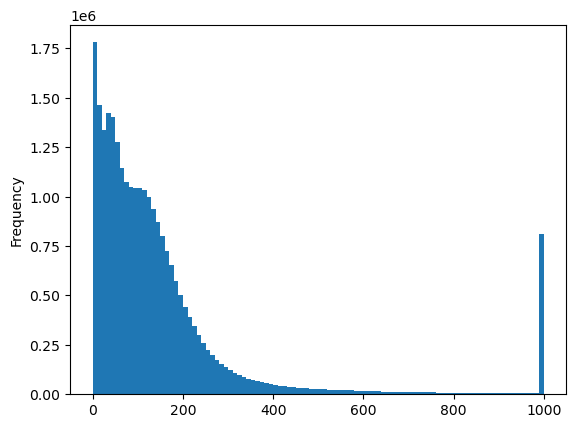

In [24]:
# NOTE: elapsed_timeはclip(0, 1e7)にする
train = train.assign(elapsed_time=lambda x: x["elapsed_time"].clip(0, 1e7) / 10000.0)
train.query("elapsed_time <= 1e7")["elapsed_time"].plot(kind="hist", bins=100, xlabel="elapsed_time")

<AxesSubplot:xlabel='level', ylabel='count'>

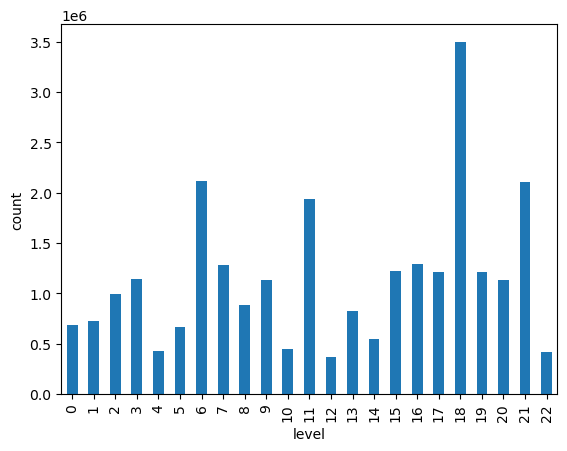

In [25]:
train["level"].value_counts().sort_index().plot(kind="bar", xlabel="level", ylabel="count")

<AxesSubplot:ylabel='Frequency'>

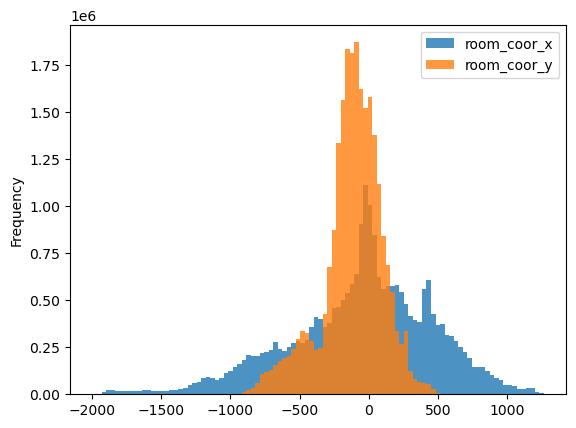

In [26]:
train[["room_coor_x", "room_coor_y"]].plot(kind="hist", bins=100, xlabel="room_coor", ylabel="count", alpha=0.8)

<AxesSubplot:ylabel='Frequency'>

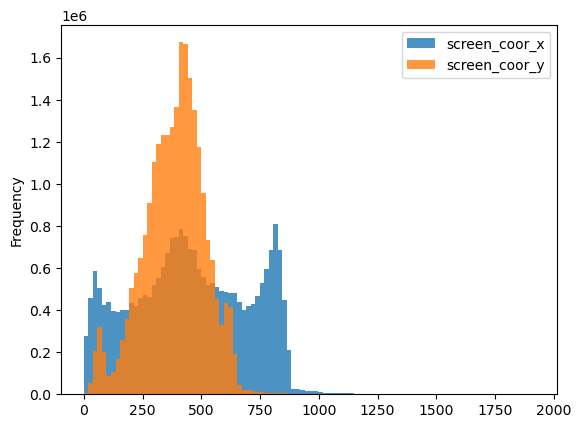

In [27]:
train[["screen_coor_x", "screen_coor_y"]].plot(kind="hist", bins=100, xlabel="screen_coor", ylabel="count", alpha=0.8)

In [28]:
s_id = 20090312431273200
train.query("session_id==@s_id")["room_fqid"].value_counts()

tunic.historicalsociety.entry              123
tunic.wildlife.center                      104
tunic.historicalsociety.cage                83
tunic.historicalsociety.frontdesk           73
tunic.library.frontdesk                     58
tunic.historicalsociety.basement            53
tunic.historicalsociety.closet_dirty        50
tunic.historicalsociety.closet              47
tunic.humanecology.frontdesk                44
tunic.historicalsociety.stacks              42
tunic.drycleaner.frontdesk                  33
tunic.kohlcenter.halloffame                 33
tunic.flaghouse.entry                       32
tunic.historicalsociety.collection          30
tunic.library.microfiche                    28
tunic.capitol_1.hall                        23
tunic.historicalsociety.collection_flag     12
tunic.capitol_0.hall                        11
tunic.capitol_2.hall                         2
Name: room_fqid, dtype: int64

In [29]:
train_labels["correct"].value_counts(normalize=True)

1    0.705635
0    0.294365
Name: correct, dtype: float64

## Count rows groupby session id

<AxesSubplot:ylabel='Frequency'>

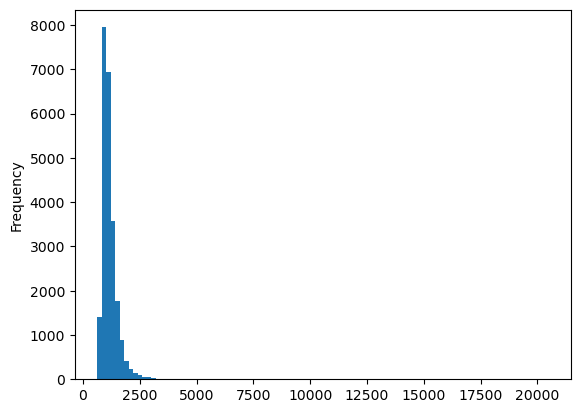

In [30]:
train.groupby("session_id")["index"].max().plot(kind="hist", bins=100, ylabel="count")

<AxesSubplot:xlabel='level', ylabel='count'>

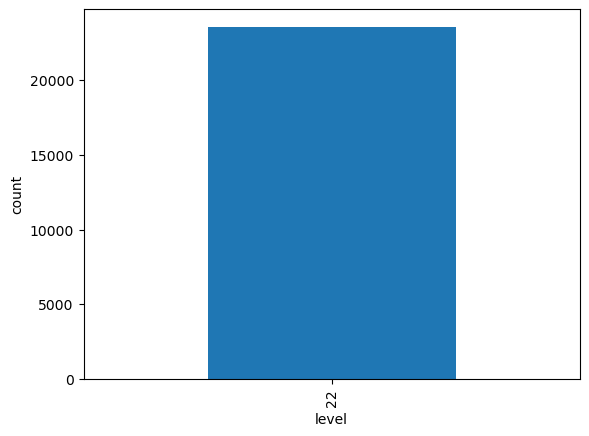

In [31]:
train.groupby("session_id")["level"].max().value_counts().sort_index().plot(kind="bar", xlabel="level", ylabel="count")

<AxesSubplot:xlabel='level', ylabel='count'>

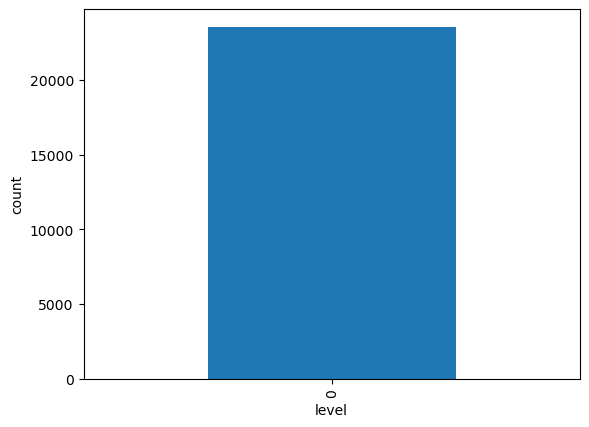

In [32]:
train.groupby("session_id")["level"].min().value_counts().sort_index().plot(kind="bar", xlabel="level", ylabel="count")